In [ ]:
import pyemu
import conda_scripts.load_datasets as lsd
import os
import pandas as pd
import numpy as np
import conda_scripts
import forward_run
import matplotlib.pyplot as plt
import conda_scripts.plot_help as ph
from conda_scripts import sv_budget
import matplotlib as mpl
import numpy as np
import shutil
import geopandas as gpd

In [ ]:
workspace = lsd.model_info.get_mod('son', True)
workspace

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline


- add farm budget processing
- add aquifer array processing
- add irrigation depth processing
- add irrigation volume processing

In [ ]:
main = 'postprocess'
fold =  'leo'

out_folder = os.path.join(main, fold)
if not os.path.exists(out_folder):
    os.makedirs(out_folder, exist_ok =True)

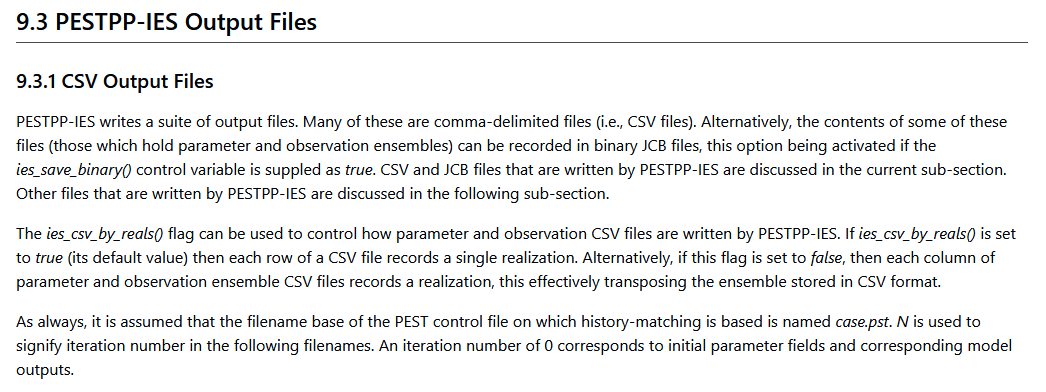
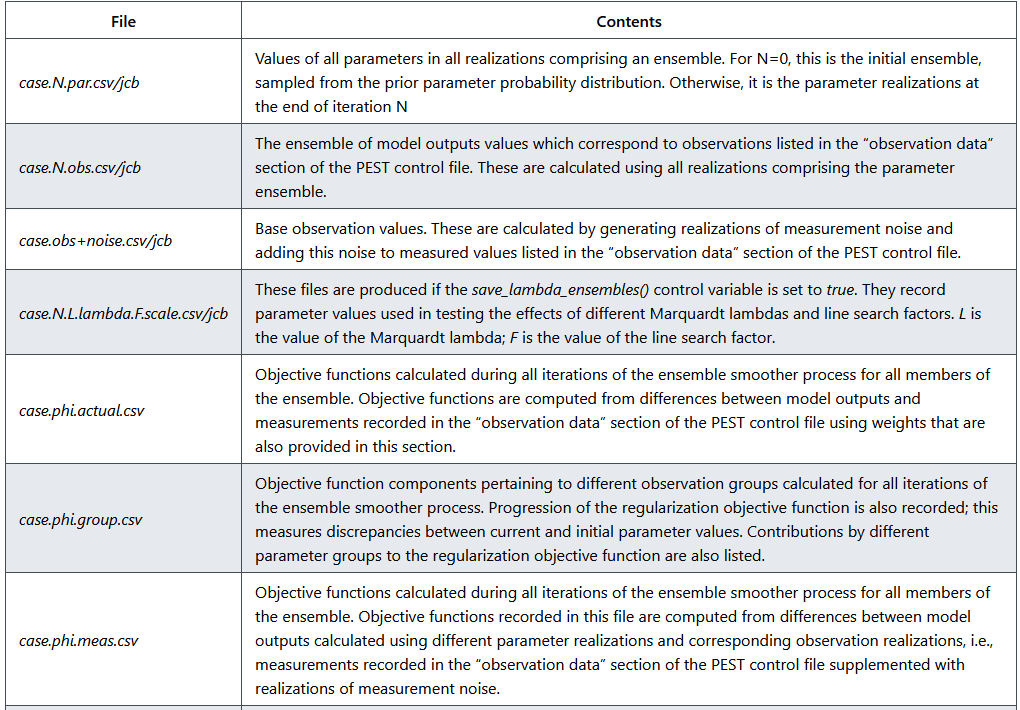
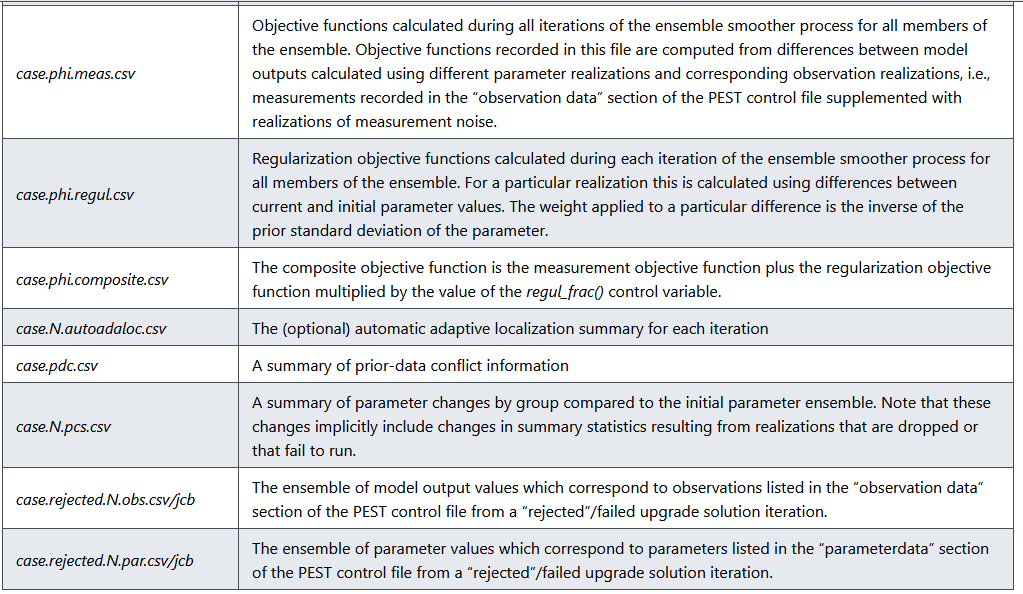

## Others

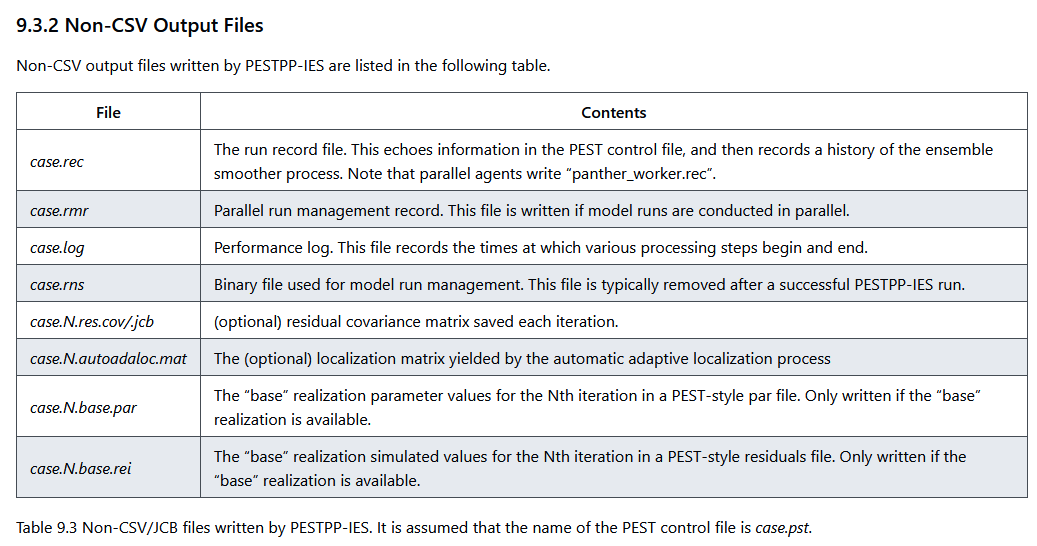

In [ ]:
ml = conda_scripts.sv_budget.load_sv_model.get_model(workspace)

In [ ]:
m_d = f_d = "C:\GSP\sv\model\pest_inputs\\PEST_PP\\leo"

In [ ]:
pstname = 'leo'
pst = pyemu.Pst(os.path.join(f_d,f"{pstname}.pst"))

In [ ]:
# pst = pyemu.Pst(os.path.join(f_d,f"{fold}.pst"))

In [ ]:
write_base_to_master = False

In [ ]:
if write_base_to_master:
    pstname = 'plum'
    pst = pyemu.Pst(os.path.join(f_d,f"{pstname}.pst"))
    
    par = pst.parameter_data
    
    par.loc[par_fin.loc['base'].index,'parval1'] =par_fin.loc['base']


    del obj.pestpp_options['ies_parameter_ensemble'] 

    pst.control_data.noptmax = -2
    pst.model_command = ['run.bat']
    pst.write(os.path.join(ml.model_ws, f'{pstname}.pst'),version = 2 )

# look at par groups phi

In [ ]:
import pathlib

In [ ]:
file = pst.filename
print(file)
p =pathlib.Path(file)


In [ ]:
def get_phi(pst):
    file = pst.filename

    p =pathlib.Path(file)

    fold = p.parents[0]
    num = 0

    rei = pathlib.Path(file.replace('.pst',f'.{num}.base.rei'))
    path = True
    while path:

        if pathlib.Path(file.replace('.pst',f'.{num}.base.rei')).exists():
            
            rei = pathlib.Path(file.replace('.pst',f'.{num}.base.rei'))
            num +=1
            path = True
        else:
            path = False
    print(rei)
    rei =  pd.read_csv(rei, skiprows=[0,1,2], sep = '\s+')

    rei.loc[:,'phi'] = (rei.loc[:,'Residual'] * rei.loc[:,'Weight'] )**2

    return rei

rei = get_phi(pst)
rei_df = rei.copy()
rei = rei.groupby('Group').sum().loc[:,'phi'].to_dict()

rei

In [ ]:
fold = 'leo'

In [ ]:



phi = pd.read_csv(os.path.join(f_d,f"{fold}.phi.actual.csv"),index_col=0)
noi = pd.read_csv(os.path.join(f_d,f"{fold}.phi.meas.csv"),index_col=0)


In [ ]:
import matplotlib as mpl

In [ ]:
mpl.rcParams["backend"] = "QtAgg"

In [ ]:
plt.show()

PESTPP-IES has conveniently kept track of all our observation data, measurement noise and the model outputs from each realization at each iteration. This now allows us to go back and look at all this information in detail should we wish to do so. We are interested in looking at (1) how model outputs compare to measured data+noise and (2) the distribution of model outputs for forecast observations.

Since PESTPP-IES evaluates a prior parameter ensemble, we can use the model outputs from that iteration (iteration zero) as a sample of the prior. We treat the model outputs from the ensemble for the final (best?) iteration as a sample of the posterior. Let's read in the files which PESTPP-IES recorded:

In [ ]:
noptmax = 4

In [ ]:
pr_oe = pyemu.ObservationEnsemble.from_csv(pst=pst,filename=os.path.join(m_d,f"{fold}.0.obs.csv"))
pt_oe = pyemu.ObservationEnsemble.from_csv(pst=pst,filename=os.path.join(m_d,"{:}.{:}.obs.csv".format(fold,noptmax)))
noise = pyemu.ObservationEnsemble.from_csv(pst=pst,filename=os.path.join(m_d,f"{fold}.obs+noise.csv"))

In [ ]:
phi_per = pd.read_csv(os.path.join(m_d,f"{fold}.phi.meas.csv"), index_col = 0)
phi_per

In [ ]:
itermax = noptmax

In [ ]:
phi_per

In [ ]:
np.percentile(phi_per.loc[itermax,'0':].dropna(),90)

In [ ]:
# good = (phi_per.loc[[itermax],'0':]< (phi_per.at[1,'mean'] + phi_per.at[1,'standard_deviation'] ))
good = (phi_per.loc[[itermax],'0':]< np.percentile(phi_per.loc[itermax,'0':].dropna(),20))
good = good.T
good = good.loc[good.values]
good.shape

In [ ]:
def filter_good(pst, good):
    obs = pst.observation_data.copy()

    return obs

filter_good(pst, good).head()

In [ ]:
pst = pyemu.Pst(os.path.join(f_d,f"{pstname}.pst"))

In [ ]:
obs = pst.observation_data.copy()
obs = obs.loc[obs.i.notnull()]
obs = obs.astype({'i':'int64', 'j':'int64'})
obs = obs.drop(columns = 'zone')

In [ ]:
obs.dtypes

In [ ]:
z = np.genfromtxt(os.path.join(ml.model_ws, 'model_arrays', 'zonation_3.csv'), delimiter = ' ')

zotther = z.copy()
zotther[zotther>9] = 0


z = conda_scripts.arich_functions.array2rc(z,'zone').astype({'zone':int,'i':int,'j':int})

aliases = {1: 'Bay', 2: 'EastSide', 3: 'SouthCent', 4: 'Kenwood', 5: 'VOM', 6: 'AguaCal',7:'WestSide',8:'CitySon',9:'Highlands'}
z.loc[:,'zone_name'] =z.loc[:,'zone'].replace(aliases)
z = z.query("zone!=0").loc[:,['i','j','zone_name']]

obs = obs.query("obgnme.str.contains('arrays')")
obs = pd.merge(obs, z, on = ['i','j'])

In [ ]:
obs

In [ ]:
pt = pt_oe.reindex(columns = obs.obsnme).T.set_index(pd.MultiIndex.from_frame(obs.loc[:,['obsnme','obgnme','i','j', 'oname','zone_name']])).map(np.log10)

pr = pr_oe.reindex(columns = obs.obsnme).T.set_index(pd.MultiIndex.from_frame(obs.loc[:,['obsnme','obgnme','i','j', 'oname','zone_name']])).map(np.log10)

# pr = pr.loc[:,pr.columns.isin(pt.columns)]

In [ ]:
pr

In [ ]:
pr.query("oname=='drn'").unstack('zone_name').stack(0).notnull().sum()

In [ ]:
obs

In [ ]:
obs.zone_name.unique()

In [ ]:
os.makedirs(os.path.join(out_folder,'arrays'),exist_ok = True)

In [ ]:
for par in obs.oname.unique():
    plt.figure()
    func_dict = {f"{par} {z}" :np.log10 for z in obs.zone_name.unique()}
    plt.suptitle(par)
    pyemu.plot_utils.ensemble_helper(ensemble={"0.5":pr.query(f"oname=='{par}'").unstack('zone_name').stack(0).rename(columns = lambda x: f"{par} {x}"), 
                                               "b":pt.query(f"oname=='{par}'").unstack('zone_name').stack(0).rename(columns = lambda x: f"{par} {x}")},
                                     filename=os.path.join(out_folder,'arrays',par+'.pdf'),
                                     # deter_vals=pst.observation_data.obsval.to_dict(), 
                                     func_dict  = func_dict)
    

In [ ]:
import os
from PyPDF2 import PdfMerger

def combine_pdfs(directory, output_file):
    # Initialize PdfMerger
    merger = PdfMerger()

    # List all PDF files in the directory
    pdf_files = [f for f in os.listdir(directory) if f.endswith('.pdf') and not 'combined'  in f]
    pdf_files.sort()  # Optional: Sort files alphabetically

    if not pdf_files:
        print("No PDF files found in the directory.")
        return

    # Append each PDF to the merger
    for pdf in pdf_files:
        pdf_path = os.path.join(directory, pdf)
        print(f"Adding {pdf_path}")
        merger.append(pdf_path)

    # Write the combined PDF to output_file
    output_path = os.path.join(directory, output_file)
    merger.write(output_path)
    merger.close()

    print(f"Combined PDF saved as {os.path.abspath(output_path)}")

# Usage
combine_pdfs(directory=os.path.join(out_folder,'arrays'), output_file='combined.pdf')

In [ ]:
from pypdf import PdfMerger

In [ ]:
df = pd.read_fwf(r"E:\srp_model\srp_model\output\output.model1_full\srphm_full_inflow_5.gag", sep ='s+',skiprows=[0],index_col = [0])

df = df.rename(columns= lambda x: x.replace('DATA:',''))

df.index = pd.to_datetime('10/1/1974')+ pd.to_timedelta(df.index, unit = "D")
df = df.loc[:,df.abs().sum()>0]
df.plot(subplots = True)